In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func

# Immport these to view table column headers & rows
from sqlalchemy.orm import sessionmaker
from sqlalchemy import select

In [5]:
# make engine for connecting to database
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model (creates base class for automap schema)
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create session (link) from Python to the DB
session = sessionmaker(bind=engine)()

# View table column headers & rows
measurement_table = select('*').select_from(Measurement)
measurement_result = session.execute(measurement_table).fetchall()
print(Measurement.__table__.columns.keys())
print(measurement_result)

['id', 'station', 'date', 'prcp', 'tobs']
[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0), (6, 'USC00519397', '2010-01-07', 0.06, 70.0), (7, 'USC00519397', '2010-01-08', 0.0, 64.0), (8, 'USC00519397', '2010-01-09', 0.0, 68.0), (9, 'USC00519397', '2010-01-10', 0.0, 73.0), (10, 'USC00519397', '2010-01-11', 0.01, 64.0), (11, 'USC00519397', '2010-01-12', 0.0, 61.0), (12, 'USC00519397', '2010-01-14', 0.0, 66.0), (13, 'USC00519397', '2010-01-15', 0.0, 65.0), (14, 'USC00519397', '2010-01-16', 0.0, 68.0), (15, 'USC00519397', '2010-01-17', 0.0, 64.0), (16, 'USC00519397', '2010-01-18', 0.0, 72.0), (17, 'USC00519397', '2010-01-19', 0.0, 66.0), (18, 'USC00519397', '2010-01-20', 0.0, 66.0), (19, 'USC00519397', '2010-01-21', 0.0, 69.0), (20, 'USC00519397', '2010-01-22', 0.0, 67.0), (21, 'USC00519397', '2010-01-23', 0.0, 67.

# Exploratory Climate Analysis

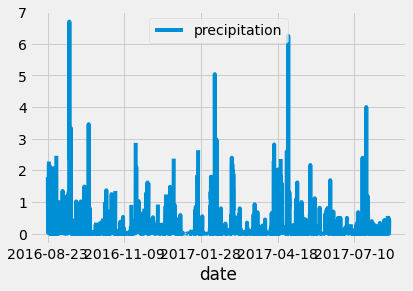

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the last data point in the database. 
## last data point will be August 23, 2017

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores (filter so only results from Aug 23, 2017 and onwards)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()
# To preview df:
# print(df.to_string(index=False))

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

# To show row with 6.7 inches of prcp (max prcp):
# prcp_max_df = df.loc[df['precipitation'] == 6.7, :]
# prcp_max_df

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

# NB: 'count' is supposed to be the number of times it rained that year
# BUT for a single date, it counts prcp value from each station as 1 count 
# (so it includes duplicate counts for the same day)

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

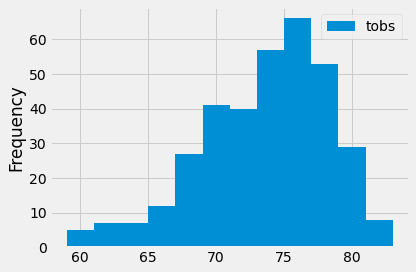

In [15]:
# Choose the station with the highest number of temperature observations.
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()

df = pd.DataFrame(results, columns=['tobs'])
# preview df:
# print(df.to_string(index=False))

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df.plot.hist(bins=12)
plt.tight_layout()

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start='%Y-%m-%d', end='%Y-%m-%d'):
   sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

   if not end:
      results = session.query(*sel).\
         filter(Measurement.date <= start).all()
      temps = list(np.ravel(results))
         
   results = session.query(*sel).\
      filter(Measurement.date >= start).\
      filter(Measurement.date <= end).all()
   temps = list(np.ravel(results))
   return temps

calc_temps('2017-06-01', '2017-06-30')

[71.0, 77.21989528795811, 83.0]

# Challenge

In [17]:
# query: what dates (years) does the data span?
results = session.query(func.min(Measurement.date), func.max(Measurement.date)).all()
results
# answer: 2010-2017 inclusive for June; 2010-2016 inclusive for Dec

[('2010-01-01', '2017-08-23')]

In [18]:
# weather stats for June 2010-2017

# precipitation level (inches)
# function takes in dates and creates a dataframe of the date and corresponding precipitation
def prcp(year, start='%Y-%m-%d', end='%Y-%m-%d'):
    # take 'avg' prcp for each day b/c each of the 9 stations provides a prcp for the same day
    results = session.query(Measurement.date, func.avg(Measurement.prcp))\
        .filter(Measurement.date >= start)\
        .filter(Measurement.date <= end)\
        .group_by(Measurement.date).all()
    
    # label columns with the year
    df = pd.DataFrame(results, columns=['date_' + str(year),'prcp_' + str(year)])
    return df

# dataframe for each year
# (there are 30 days in June)
df2010 = prcp(2010, '2010-06-01', '2010-06-30')
df2011 = prcp(2011, '2011-06-01', '2011-06-30')
df2012 = prcp(2012, '2012-06-01', '2012-06-30')
df2013 = prcp(2013, '2013-06-01', '2013-06-30')
df2014 = prcp(2014, '2014-06-01', '2014-06-30')
df2015 = prcp(2015, '2015-06-01', '2015-06-30')
df2016 = prcp(2016, '2016-06-01', '2016-06-30')
df2017 = prcp(2017, '2017-06-01', '2017-06-30')

# merge dataframes for all years
prcp_df = pd.DataFrame.join(df2010, other=[df2011, df2012, df2013, df2014, df2015, df2016, df2017])

# drop date columns
prcp_df = prcp_df.loc[:,['prcp_2010','prcp_2011','prcp_2012','prcp_2013','prcp_2014','prcp_2015','prcp_2016',
                         'prcp_2017']]

# create list of average daily prcp for each day in June
avg_prcp_june = prcp_df.mean(axis=1)

# avg daily prcp in June for each year
avg_prcp_june_perYear = prcp_df.mean(axis=0)

# stats of average daily prcp in June
# Note: Hawaii Weather API says precipitation is in inches
avg_prcp_june.describe()

count    30.000000
mean      0.140569
std       0.055183
min       0.044960
25%       0.102249
50%       0.126213
75%       0.162243
max       0.288234
dtype: float64

In [19]:
# median avg daily prcp in June
median_prcp_june = np.median(avg_prcp_june)
median_prcp_june

0.12621279761904763

In [20]:
# weather stats for June 2010-2017 continued

# precipitation, # of days of
# function gives a count of days of prcp (for june of each year) as a df
def prcp_count(df, col, year):     
    # get the count
    count = df.loc[df[col]>0, [col]].count().to_list()
    
    # turn dictionary into dataframe
    count_dict = {}
    for num in count:
        count_dict[year] = num
        count_df = pd.DataFrame.from_dict(count_dict, orient='index', columns=['prcp_count'])
        
    return count_df

# prcp count for each year
count_df2010 = prcp_count(df2010, 'prcp_2010', '2010')
count_df2011 = prcp_count(df2011, 'prcp_2011', '2011')
count_df2012 = prcp_count(df2012, 'prcp_2012', '2012')
count_df2013 = prcp_count(df2013, 'prcp_2013', '2013')
count_df2014 = prcp_count(df2014, 'prcp_2014', '2014')
count_df2015 = prcp_count(df2015, 'prcp_2015', '2015')
count_df2016 = prcp_count(df2016, 'prcp_2016', '2016')
count_df2017 = prcp_count(df2017, 'prcp_2017', '2017')

# concatenate yearly prcp counts into 1 df
count_df = pd.concat([count_df2010, count_df2011, count_df2012, count_df2013, count_df2014, count_df2015, count_df2016, count_df2017])

# avg prcp count for june (across all years 2010-2017)
avg_prcp_count_june = count_df['prcp_count'].mean()
print(f'From 2010 to 2017, the average number of days in June with precipitation was {avg_prcp_count_june} days.')

From 2010 to 2017, the average number of days in June with precipitation was 28.75 days.


In [21]:
# weather stats for June 2010-2017 continued

# temperature
# function takes in dates and creates a dataframe of the date and corresponding temperature
def tobs(year, start='%Y-%m-%d', end='%Y-%m-%d'):
    # take 'avg' temp b/c each of the 9 stations provides a temp for the same day
    results = session.query(Measurement.date, func.avg(Measurement.tobs))\
        .filter(Measurement.date >= start)\
        .filter(Measurement.date <= end)\
        .group_by(Measurement.date).all()
    
    # label columns with the year
    df = pd.DataFrame(results, columns=['date_' + str(year),'tobs_' + str(year)])
    return df

# dataframe for each year
# (there are 30 days in June)
df2010 = tobs(2010, '2010-06-01', '2010-06-30')
df2011 = tobs(2011, '2011-06-01', '2011-06-30')
df2012 = tobs(2012, '2012-06-01', '2012-06-30')
df2013 = tobs(2013, '2013-06-01', '2013-06-30')
df2014 = tobs(2014, '2014-06-01', '2014-06-30')
df2015 = tobs(2015, '2015-06-01', '2015-06-30')
df2016 = tobs(2016, '2016-06-01', '2016-06-30')
df2017 = tobs(2017, '2017-06-01', '2017-06-30')

# merge dataframes for all years
tobs_df = pd.DataFrame.join(df2010, other=[df2011, df2012, df2013, df2014, df2015, df2016, df2017])

# drop date columns
tobs_df = tobs_df.loc[:,['tobs_2010','tobs_2011','tobs_2012','tobs_2013','tobs_2014','tobs_2015','tobs_2016',
                         'tobs_2017']]

# create list of average daily tobs for each day in June
avg_tobs_june = tobs_df.mean(axis=1)

# avg daily tobs in June for each year
avg_tobs_june_perYear = tobs_df.mean(axis=0)

# stats of average daily tobs in June
# tobs is in Fahrenheit
avg_tobs_june.describe()

count    30.000000
mean     75.010911
std       0.569275
min      73.615575
25%      74.702505
50%      75.117956
75%      75.452319
max      75.943452
dtype: float64

In [22]:
# median avg daily tobs in June
median_tobs_june = np.median(avg_tobs_june)
median_tobs_june

75.11795634920634

In [23]:
# weather stats for Dec 2010-2016
# (no data available for Dec 2017)

# precipitation level (inches)
# function takes in dates and creates a dataframe of the date and corresponding precipitation
def prcp(year, start='%Y-%m-%d', end='%Y-%m-%d'):
    # take 'avg' prcp b/c each of the 9 stations provides a prcp for the same day
    results = session.query(Measurement.date, func.avg(Measurement.prcp))\
        .filter(Measurement.date >= start)\
        .filter(Measurement.date <= end)\
        .group_by(Measurement.date).all()
    
    # label dataframe with the year
    df = pd.DataFrame(results, columns=['date_' + str(year),'prcp_' + str(year)])
    return df

# dataframe for each year
# (there are 31 days in Dec)
df2010 = prcp(2010, '2010-12-01', '2010-12-31')
df2011 = prcp(2011, '2011-12-01', '2011-12-31')
df2012 = prcp(2012, '2012-12-01', '2012-12-31')
df2013 = prcp(2013, '2013-12-01', '2013-12-31')
df2014 = prcp(2014, '2014-12-01', '2014-12-31')
df2015 = prcp(2015, '2015-12-01', '2015-12-31')
df2016 = prcp(2016, '2016-12-01', '2016-12-31')

# merge dataframes for all years
prcp_df = pd.DataFrame.join(df2010, other=[df2011, df2012, df2013, df2014, df2015, df2016])
prcp_df

# drop date columns
prcp_df = prcp_df.loc[:,['prcp_2010','prcp_2011','prcp_2012','prcp_2013','prcp_2014','prcp_2015','prcp_2016']]

# average daily prcp for each day in Dec
avg_prcp_dec = prcp_df.mean(axis=1)

# avg daily prcp in Dec for each year
avg_prcp_dec_perYear = prcp_df.mean(axis=0)

# stats of average daily prcp in Dec
# prcp is in inches
avg_prcp_dec.describe()

count    31.000000
mean      0.215665
std       0.150109
min       0.022960
25%       0.121483
50%       0.166000
75%       0.273532
max       0.703954
dtype: float64

In [24]:
# median avg daily prcp in Dec
median_prcp_dec = np.median(avg_prcp_dec)
median_prcp_dec

0.16599999999999998

In [25]:
# weather stats for Dec 2010-2016 continued

# precipitation, # of days of
# function gives a prcp count for Dec of each year as a df
def prcp_count(df, col, year):     
    count = df.loc[df[col]>0, [col]].count().to_list()
    
    # convert dictionary to dataframe
    count_dict = {}    
    for num in count:
        count_dict[year] = num
        count_df = pd.DataFrame.from_dict(count_dict, orient='index', columns=['prcp_count'])
        
    return count_df

# prcp count for each year
count_df2010 = prcp_count(df2010, 'prcp_2010', '2010')
count_df2011 = prcp_count(df2011, 'prcp_2011', '2011')
count_df2012 = prcp_count(df2012, 'prcp_2012', '2012')
count_df2013 = prcp_count(df2013, 'prcp_2013', '2013')
count_df2014 = prcp_count(df2014, 'prcp_2014', '2014')
count_df2015 = prcp_count(df2015, 'prcp_2015', '2015')
count_df2016 = prcp_count(df2016, 'prcp_2016', '2016')

# concatenate yearly prcp counts into 1 df
count_df = pd.concat([count_df2010, count_df2011, count_df2012, count_df2013, count_df2014, count_df2015, count_df2016])

# avg prcp count for Dec
avg_prcp_count_dec = count_df['prcp_count'].mean()
print(f'From 2010 to 2017, the average number of days in Dec with precipitation was {avg_prcp_count_dec} days.')

From 2010 to 2017, the average number of days in Dec with precipitation was 28.142857142857142 days.


In [26]:
# weather stats for Dec 2010-2016 continued
# (no data available for Dec 2017)

# temperature
# function takes in dates and creates a dataframe of the date and corresponding temperature
def tobs(year, start='%Y-%m-%d', end='%Y-%m-%d'):
    # take 'avg' temp b/c each of the 9 stations provides a temp for the same day
    results = session.query(Measurement.date, func.avg(Measurement.tobs))\
        .filter(Measurement.date >= start)\
        .filter(Measurement.date <= end)\
        .group_by(Measurement.date).all()
    
    # label columns with the year
    df = pd.DataFrame(results, columns=['date_' + str(year),'tobs_' + str(year)])
    return df

# dataframe for each year
# (there are 31 days in Dec)
df2010 = tobs(2010, '2010-12-01', '2010-12-31')
df2011 = tobs(2011, '2011-12-01', '2011-12-31')
df2012 = tobs(2012, '2012-12-01', '2012-12-31')
df2013 = tobs(2013, '2013-12-01', '2013-12-31')
df2014 = tobs(2014, '2014-12-01', '2014-12-31')
df2015 = tobs(2015, '2015-12-01', '2015-12-31')
df2016 = tobs(2016, '2016-12-01', '2016-12-31')

# merge dataframes for all years
tobs_df = pd.DataFrame.join(df2010, other=[df2011, df2012, df2013, df2014, df2015, df2016])

# drop date columns
tobs_df = tobs_df.loc[:,['tobs_2010','tobs_2011','tobs_2012','tobs_2013','tobs_2014','tobs_2015','tobs_2016']]

# create list of average daily tobs for each day in Dec
avg_tobs_dec = tobs_df.mean(axis=1)

# avg daily tobs in Dec for each year
avg_tobs_dec_perYear = tobs_df.mean(axis=0)

# stats of average daily tobs in Dec
# tobs is in fahrenheit
avg_tobs_dec.describe()

count    31.000000
mean     71.105334
std       1.072431
min      68.246939
25%      70.401786
50%      71.059070
75%      71.897392
max      72.931519
dtype: float64

In [27]:
# median avg daily tobs in Dec
median_tobs_dec = np.median(avg_tobs_dec)
median_tobs_dec

71.05907029478458

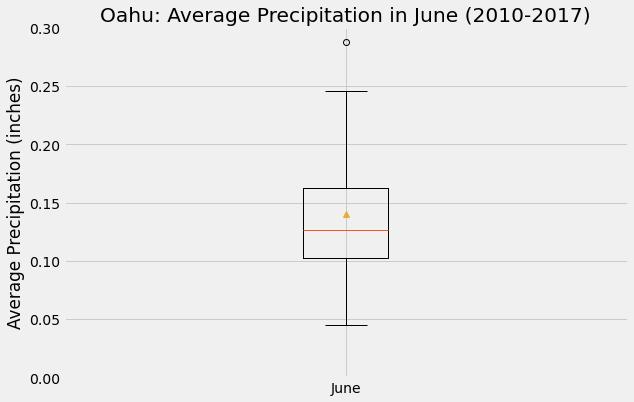

In [28]:
# box & whisker plot: June prcp
x_labels = ["June"]
fig, ax = plt.subplots(figsize=(9,6))
ax.boxplot(avg_prcp_june, labels=x_labels, showmeans=True)

ax.set_title('Oahu: Average Precipitation in June (2010-2017)')
ax.set_ylabel('Average Precipitation (inches)')
ax.set_yticks(np.arange(0, 0.35, step=0.05))

plt.show()

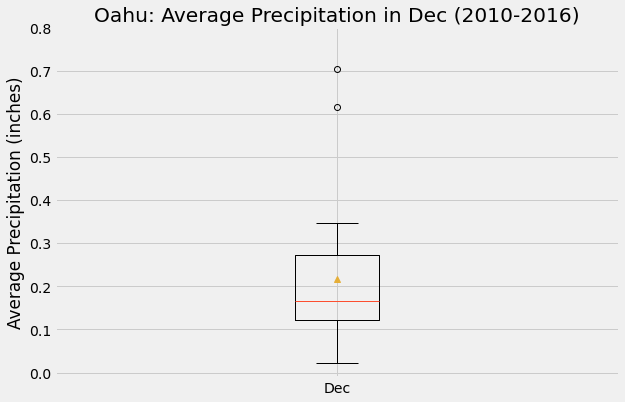

In [29]:
# box & whisker plot: Dec prcp
x_labels = ["Dec"]
fig, ax = plt.subplots(figsize=(9,6))
ax.boxplot(avg_prcp_dec, labels=x_labels, showmeans=True)

ax.set_title('Oahu: Average Precipitation in Dec (2010-2016)')
ax.set_ylabel('Average Precipitation (inches)')
ax.set_yticks(np.arange(0, 0.9, step=0.1))

plt.show()

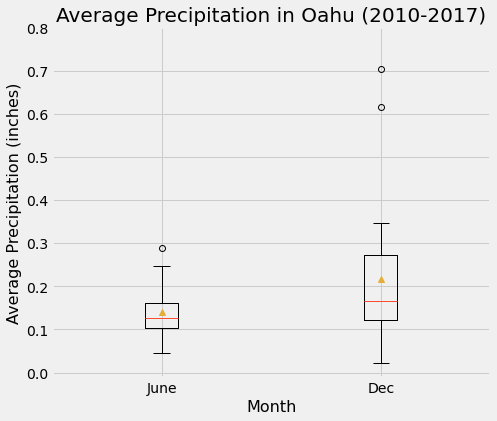

In [30]:
# add June & Dec prcp box-and-whisker plots to the same graph
x_labels = ["June", "Dec"]
prcp_data = [avg_prcp_june, avg_prcp_dec]
fig, ax = plt.subplots(figsize=(7, 6))

ax.set_title('Average Precipitation in Oahu (2010-2017)',fontsize=20)
ax.set_ylabel('Average Precipitation (inches)',fontsize=16)
ax.set_xlabel("Month",fontsize=16)
ax.boxplot(prcp_data, labels=x_labels, showmeans=True)
ax.set_yticks(np.arange(0, 0.9, step=0.1))

plt.savefig('analysis/prcp.png', bbox_inches='tight')

plt.show()

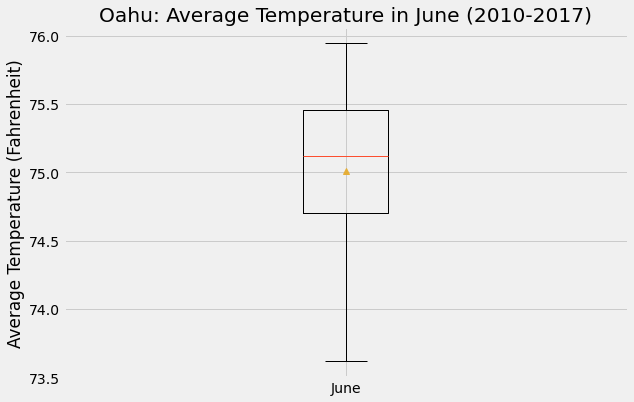

In [31]:
# box & whisker plot: June tobs
x_labels = ["June"]
fig, ax = plt.subplots(figsize=(9,6))
ax.boxplot(avg_tobs_june, labels=x_labels, showmeans=True)

ax.set_title('Oahu: Average Temperature in June (2010-2017)')
ax.set_ylabel('Average Temperature (Fahrenheit)')
ax.set_yticks(np.arange(73.5, 76.5, step=0.5))

plt.show()

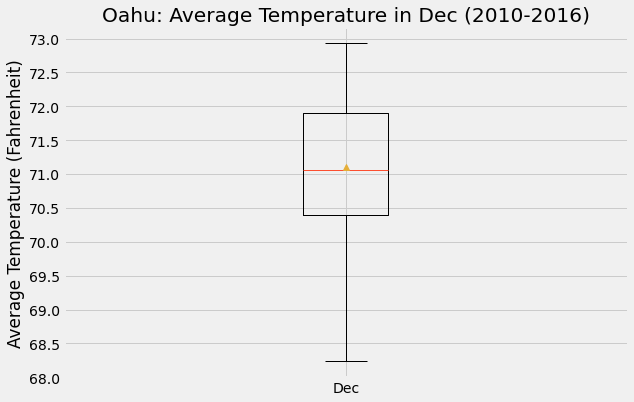

In [32]:
# box & whisker plot: Dec tobs
x_labels = ["Dec"]
fig, ax = plt.subplots(figsize=(9,6))
ax.boxplot(avg_tobs_dec, labels=x_labels, showmeans=True)

ax.set_title('Oahu: Average Temperature in Dec (2010-2016)')
ax.set_ylabel('Average Temperature (Fahrenheit)')
ax.set_yticks(np.arange(68, 73.5, step=0.5))

plt.show()

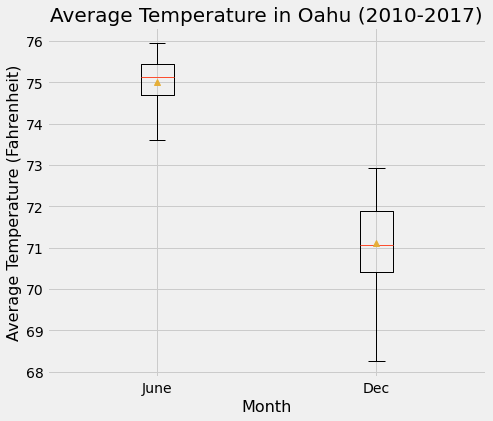

In [33]:
# add June & Dec tobs box-and-whisker plots to the same graph
x_labels = ["June", "Dec"]
tobs_data = [avg_tobs_june, avg_tobs_dec]
fig, ax = plt.subplots(figsize=(7, 6))

ax.set_title('Average Temperature in Oahu (2010-2017)',fontsize=20)
ax.set_ylabel('Average Temperature (Fahrenheit)',fontsize=16)
ax.set_xlabel("Month",fontsize=16)
ax.boxplot(tobs_data, labels=x_labels, showmeans=True)
ax.set_yticks(np.arange(68, 77, step=1))

plt.savefig('analysis/tobs.png', bbox_inches='tight')

plt.show()

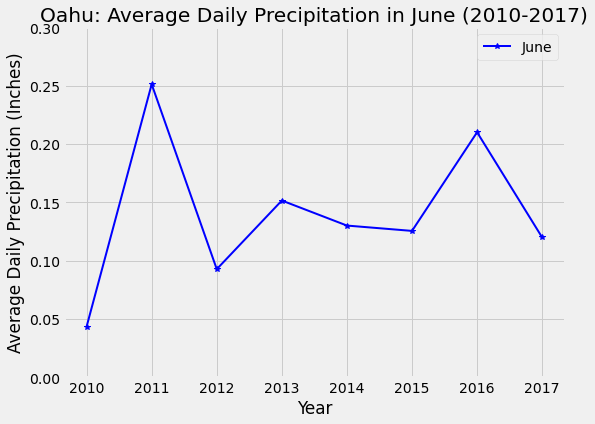

In [34]:
# avg daily prcp in June 2010-2017

x_axis = range(2010, 2018, 1)

plt.subplots(figsize=(8,6))
plt.plot(x_axis, avg_prcp_june_perYear, marker="*", color="blue", linewidth=2, label='June')

plt.title("Oahu: Average Daily Precipitation in June (2010-2017)")
plt.xlabel("Year")
plt.ylabel("Average Daily Precipitation (Inches)")
plt.legend()

plt.ylim(0, 0.3)

plt.show()

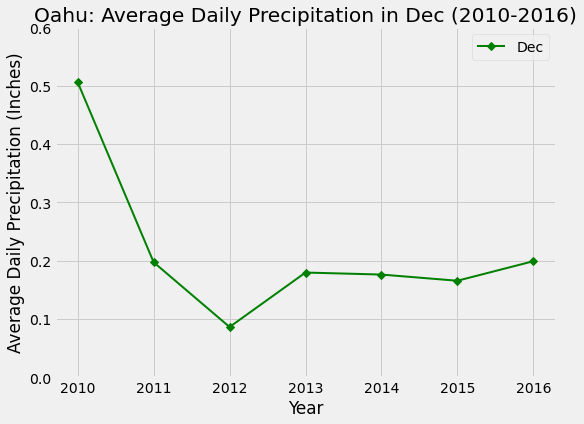

In [35]:
# avg daily prcp in Dec 2010-2016

x_axis = range(2010, 2017, 1)

plt.subplots(figsize=(8,6))
plt.plot(x_axis, avg_prcp_dec_perYear, marker="D", color="green", linewidth=2, label='Dec')

plt.title("Oahu: Average Daily Precipitation in Dec (2010-2016)")
plt.xlabel("Year")
plt.ylabel("Average Daily Precipitation (Inches)")
plt.legend()

plt.ylim(0, 0.6)

plt.show()

In [36]:
# create dataframe of avg prcp per year that includes both June & Dec

june_prcp_df = pd.DataFrame.reset_index(avg_prcp_june_perYear, drop=True)
dec_prcp_df = pd.DataFrame.reset_index(avg_prcp_dec_perYear, drop=True)

prcp_perYear_dict = {'Year': np.arange(2010, 2018, 1),
                  'June': june_prcp_df,
                  'December': dec_prcp_df}
prcp_perYear_df = pd.DataFrame(prcp_perYear_dict).set_index('Year')
prcp_perYear_df

,June,December
Year,,
2010,0.043464,0.505766
2011,0.251237,0.197248
2012,0.092712,0.086268
2013,0.151552,0.179635
2014,0.130091,0.176168
2015,0.125512,0.165563
2016,0.210077,0.199009
2017,0.119904,NaN


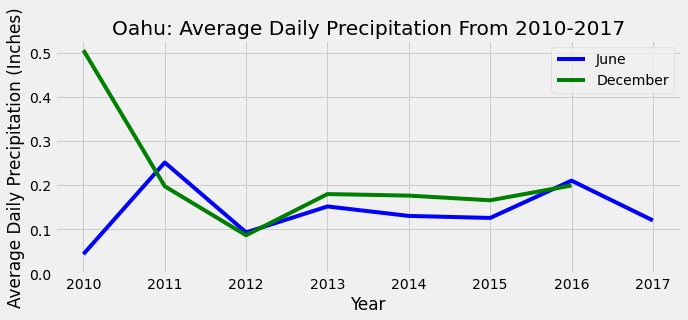

In [37]:
# June and Dec line graphs together

# avg daily prcp per year (2010-2017)
color_scheme = ["blue", "green"]
ax = prcp_perYear_df.plot(figsize=(10,4), color=color_scheme)
ax.set_title("Oahu: Average Daily Precipitation From 2010-2017")
ax.set_ylabel("Average Daily Precipitation (Inches)")
ax.set_yticks(np.arange(0, 0.6, step=0.1))
ax.legend(loc="best", mode="Expanded")

plt.savefig('analysis/prcp_perYear.png', bbox_inches='tight')

plt.show()

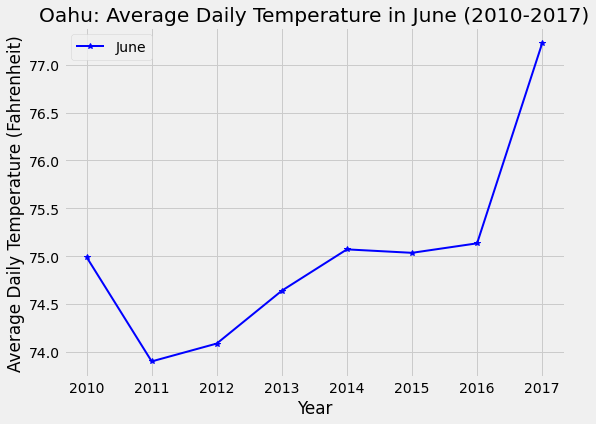

In [38]:
# avg daily tobs in June 2010-2017

x_axis = range(2010, 2018, 1)

plt.subplots(figsize=(8,6))
plt.plot(x_axis, avg_tobs_june_perYear, marker="*", color="blue", linewidth=2, label='June')

plt.title("Oahu: Average Daily Temperature in June (2010-2017)")
plt.xlabel("Year")
plt.ylabel("Average Daily Temperature (Fahrenheit)")
plt.legend()

plt.show()

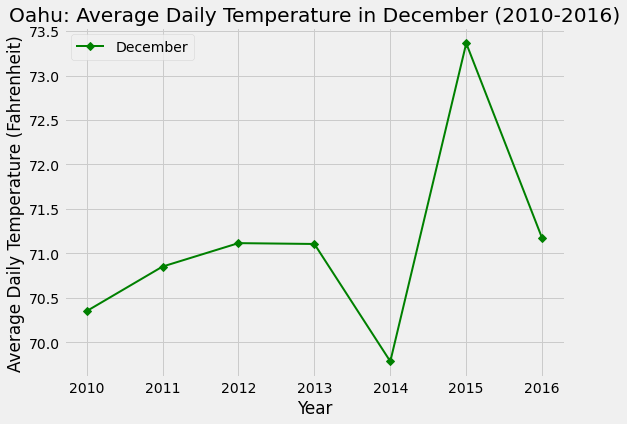

In [39]:
# avg daily tobs in Dec 2010-2016

x_axis = range(2010, 2017, 1)

plt.subplots(figsize=(8,6))
plt.plot(x_axis, avg_tobs_dec_perYear, marker="D", color="green", linewidth=2, label='December')

plt.title("Oahu: Average Daily Temperature in December (2010-2016)")
plt.xlabel("Year")
plt.ylabel("Average Daily Temperature (Fahrenheit)")
plt.legend()

plt.show()

In [40]:
# create dataframe of avg tobs per year that includes June & Dec

june_tobs_df = pd.DataFrame.reset_index(avg_tobs_june_perYear, drop=True)
dec_tobs_df = pd.DataFrame.reset_index(avg_tobs_dec_perYear, drop=True)

tobs_perYear_dict = {'Year': np.arange(2010, 2018, 1),
                  'June': june_tobs_df,
                  'December': dec_tobs_df}
tobs_perYear_df = pd.DataFrame(tobs_perYear_dict).set_index('Year')
tobs_perYear_df

,June,December
Year,,
2010,74.990807,70.349373
2011,73.902447,70.850998
2012,74.088757,71.114772
2013,74.640476,71.105300
2014,75.071706,69.783948
2015,75.035635,73.363671
2016,75.134762,71.169278
2017,77.222698,NaN


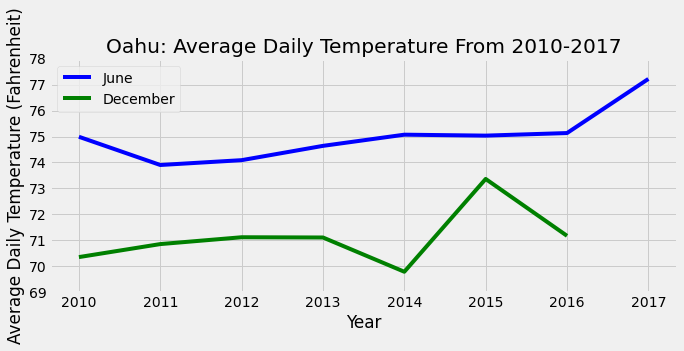

In [41]:
# June and Dec line graphs together

# avg daily tobs per year (2010-2017)
color_scheme = ["blue", "green"]
ax = tobs_perYear_df.plot(figsize=(10,4), color=color_scheme)
ax.set_title("Oahu: Average Daily Temperature From 2010-2017")
ax.set_ylabel("Average Daily Temperature (Fahrenheit)")
ax.set_yticks(np.arange(69, 79, step=1))
ax.legend(loc="best", mode="Expanded")

plt.savefig('analysis/tobs_perYear.png', bbox_inches='tight')

plt.show()